# YouTube trending videos

In [21]:
%matplotlib inline
import os
import matplotlib.pyplot as plt
import pandas as pd
from tokenizers import Tokenizer
from tqdm.notebook import tqdm
import nltk
import re
import string
import math
import json
from pandas.plotting import scatter_matrix

from categories import get_categories_dict

## Etap 1 - Atrybuty tekstowe

### Opis atrybutów

W obu zbiorach danych występują następujące atrybuty:
- **video_id** - identyfikator filmu
- **trending_date** - data pojawienia się w sekcji "trending"
- **title** - tytuł filmu,
- **channel_title** - nazwa kanału,
- **category_id** - identyfikator kategorii w do jakiego należy film,
- **publish_time** - data publikacji filmu,
- **tags** - tagi, którymi został oznaczony film,
- **views** - liczba wyświetleń filmu,
- **likes** - liczba polubień filmu,
- **dislikes** - liczba zaznaczeń "Nie podoba mi się" danego filmu,
- **comment_count** - liczba komentarzy pod filmem,
- **thumbnail_link** - url prowadzący do obrazka filmu,
- **comments_disabled** - zmienna logiczna wskazująca na zabronienie komentowania filmu,
- **ratings_disabled** - zmienna logiczna wskazująca na zabronienie oceniania filmu,
- **video_error_or_removed** - zmienna logiczna wskazująca na błąd w filmie lub jego usunięcie,
- **description** - opis filmu

### Wczytanie danych

In [2]:
gb_videos = pd.read_csv(os.path.join("youtube_data", "GB_videos_5p.csv"), sep=";")
us_videos = pd.read_csv(os.path.join("youtube_data", "US_videos_5p.csv"), sep=";")
videos = pd.concat([gb_videos, us_videos])
videos = videos.rename(columns={"description ":"description"})
videos.head(10)

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
0,Jw1Y-zhQURU,17.14.11,John Lewis Christmas Ad 2017 - #MozTheMonster,John Lewis,NaN,2017-11-10T07:38:29.000Z,"christmas|""john lewis christmas""|""john lewis""|...",7224515,55681,10247,9479,https://i.ytimg.com/vi/Jw1Y-zhQURU/default.jpg,False,False,False,Click here to continue the story and make your...
1,3s1rvMFUweQ,17.14.11,Taylor Swift: …Ready for It? (Live) - SNL,Saturday Night Live,NaN,2017-11-12T06:24:44.000Z,"SNL|""Saturday Night Live""|""SNL Season 43""|""Epi...",1053632,25561,2294,2757,https://i.ytimg.com/vi/3s1rvMFUweQ/default.jpg,False,False,False,Musical guest Taylor Swift performs …Ready for...
2,n1WpP7iowLc,17.14.11,Eminem - Walk On Water (Audio) ft. Beyoncé,EminemVEVO,NaN,2017-11-10T17:00:03.000Z,"Eminem|""Walk""|""On""|""Water""|""Aftermath/Shady/In...",17158579,787420,43420,125882,https://i.ytimg.com/vi/n1WpP7iowLc/default.jpg,False,False,False,Eminem's new track Walk on Water ft. Beyoncé i...
3,PUTEiSjKwJU,17.14.11,Goals from Salford City vs Class of 92 and Fri...,Salford City Football Club,NaN,2017-11-13T02:30:38.000Z,"Salford City FC|""Salford City""|""Salford""|""Clas...",27833,193,12,37,https://i.ytimg.com/vi/PUTEiSjKwJU/default.jpg,False,False,False,Salford drew 4-4 against the Class of 92 and F...
4,rHwDegptbI4,17.14.11,Dashcam captures truck's near miss with child ...,Cute Girl Videos,NaN,2017-11-13T01:45:13.000Z,[none],9815,30,2,30,https://i.ytimg.com/vi/rHwDegptbI4/default.jpg,False,False,False,Dashcam captures truck's near miss with child ...
5,AumaWl0TNBo,17.14.11,How My Relationship Started!,PointlessBlogVlogs,NaN,2017-11-11T17:00:00.000Z,"pointlessblog|""pointlessblogtv""|""pointlessblog...",1182775,52708,1431,2333,https://i.ytimg.com/vi/AumaWl0TNBo/default.jpg,False,False,False,► HOW MY RELATIONSHIP STARTED!\n► PB Merch • h...
6,2Vv-BfVoq4g,17.14.11,Ed Sheeran - Perfect (Official Music Video),Ed Sheeran,NaN,2017-11-09T11:04:14.000Z,"edsheeran|""ed sheeran""|""acoustic""|""live""|""cove...",33523622,1634124,21082,85067,https://i.ytimg.com/vi/2Vv-BfVoq4g/default.jpg,False,False,False,🎧: https://ad.gt/yt-perfect\n💰: https://atlant...
7,#NAZWA?,17.14.11,CHRISTMAS HAS GONE TO MY HEAD,MoreZoella,NaN,2017-11-10T19:19:43.000Z,"zoe sugg|""zoella""|""zoe""|""vlog""|""vlogging""|""vlo...",1164201,57309,749,624,https://i.ytimg.com/vi/-N5eucPMTTc/default.jpg,False,False,False,CHRISTMAS HAS GONE TO MY HEAD\nPrevious Vlog: ...
8,LMCuKltaY3M,17.14.11,Elbow - Golden Slumbers (John Lewis Advert 2017),ElbowVEVO,NaN,2017-11-10T08:00:01.000Z,"Elbow|""Golden""|""Slumbers""|""Polydor""|""Alternative""",154494,2163,147,211,https://i.ytimg.com/vi/LMCuKltaY3M/default.jpg,False,False,False,"“Golden Slumbers”, originally by The Beatles, ..."
9,9t9u_yPEidY,17.14.11,"Jennifer Lopez - Amor, Amor, Amor (Official Vi...",JenniferLopezVEVO,NaN,2017-11-10T15:00:00.000Z,"Jennifer Lopez ft. Wisin|""Jennifer Lopez ft. W...",9548677,190084,15015,11473,https://i.ytimg.com/vi/9t9u_yPEidY/default.jpg,False,False,False,"Jennifer Lopez ft. Wisin - Amor, Amor, Amor (O..."


## TODO preprocessing tagów pod filmami

warto zwrócić uwagę, że już 3 miejsce pod względem liczności to filmy bez tagów !!

In [3]:
# TAGS PREPROCESSING
videos["tags"] = videos["tags"].str.replace('"', "")
tags = videos["tags"].str.split("|").apply(pd.Series, 1).stack()
tags.index = tags.index.droplevel(-1)
tags.name = "tags"
tags = tags.to_frame()
unique_tags = tags["tags"].value_counts() #
unique_tags = unique_tags.rename_axis("tag").reset_index(name="count")
unique_tags.describe()

,count
count,72467.000000
mean,20.818055
std,67.668262
min,1.000000
25%,5.000000
50%,9.000000
75%,18.000000
max,6232.000000


                                   tag  count
0                                funny   6232
1                               comedy   5253
2                               [none]   3545
3                                music   3274
4                                  Pop   2836
...                                ...    ...
72462                          ambrose      1
72463  sp:dt=2018-04-24T20:00:00-04:00      1
72464                    Boogie Nights      1
72465                          marches      1
72466                 internet freedom      1

[72467 rows x 2 columns]


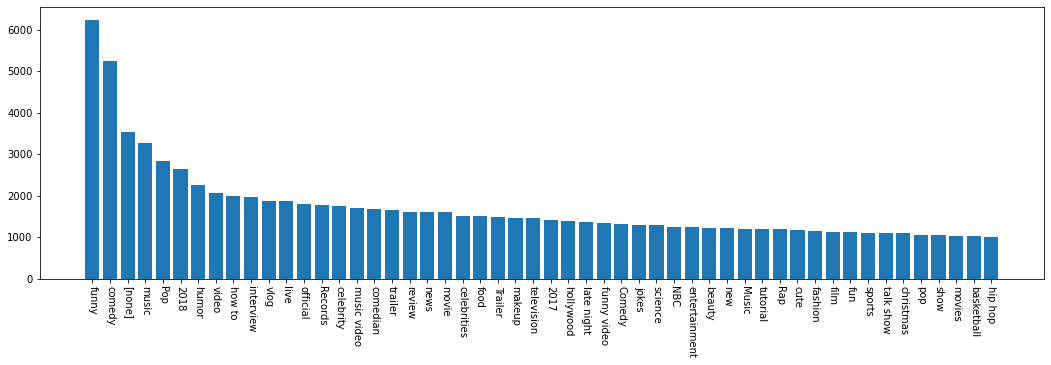

In [4]:
print(unique_tags)
unique_tags = unique_tags[unique_tags["count"] > 1000]
plt.subplots(figsize=(18,5))
plt.bar(unique_tags["tag"], unique_tags["count"])
plt.xticks(rotation=270)
plt.show()


### Preprocessing tytułów kanałów

In [5]:
channel_titles = videos["channel_title"]
unique_channel_titles = videos["channel_title"].value_counts()
unique_channel_titles = unique_channel_titles.rename_axis("channel_title").reset_index(name="count")
unique_channel_titles.describe()

,count
count,3099.000000
mean,25.771217
std,41.908339
min,1.000000
25%,5.000000
50%,11.000000
75%,27.000000
max,405.000000


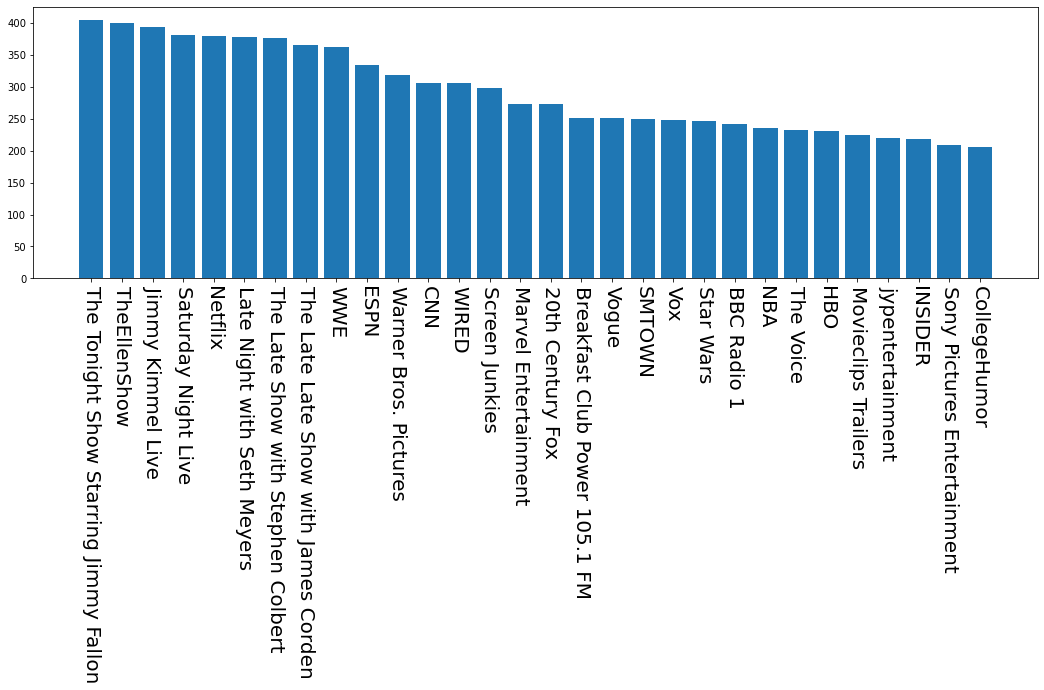

In [6]:
unique_channel_titles = unique_channel_titles[unique_channel_titles["count"] > 200]
plt.subplots(figsize=(18,5))
plt.bar(unique_channel_titles["channel_title"], unique_channel_titles["count"])
plt.xticks(rotation=270, fontsize=20)
plt.show()


### Rozkłady zmiennych logicznych


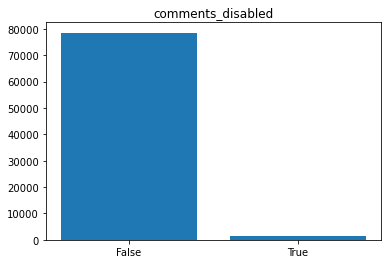

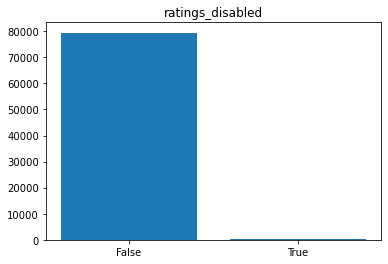

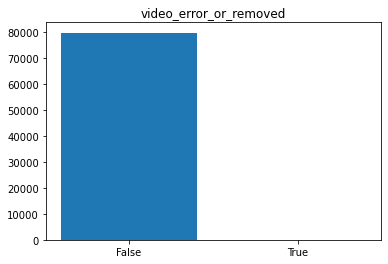

In [7]:
bool_attrs = ["comments_disabled", "ratings_disabled", "video_error_or_removed"]
for attr in bool_attrs:
    attr_c = videos[attr].value_counts()
    attr_c = attr_c.rename_axis(attr).reset_index(name="count")
    plt.title(attr)
    plt.bar(["False", "True"], attr_c["count"])
    plt.show()

### Atrybuty liczbowe


ciekwaw spostrzerzenie - minimum like, dislike i commet są zerami,

na wykresie kategorii pominięto wartości nan, ponieważ jest ich bardzo dużo (obliczono niżej)

skomentować boxlpoty

In [8]:
videos.describe()

,category_id,views,likes,dislikes,comment_count
count,3932.000000,7.986500e+04,7.986500e+04,7.986500e+04,7.986500e+04
mean,18.459563,4.091166e+06,1.036262e+05,5.612328e+03,1.070850e+04
std,7.740292,1.439125e+07,2.957265e+05,4.124462e+04,4.443679e+04
min,1.000000,5.490000e+02,0.000000e+00,0.000000e+00,0.000000e+00
25%,10.000000,2.464170e+05,5.642000e+03,2.010000e+02,6.420000e+02
50%,22.000000,7.961060e+05,2.092200e+04,7.120000e+02,2.099000e+03
75%,24.000000,2.535704e+06,7.824800e+04,2.527000e+03,7.220000e+03
max,43.000000,4.245389e+08,5.613827e+06,1.944971e+06,1.626501e+06


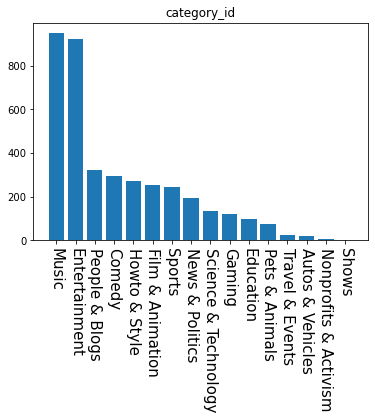

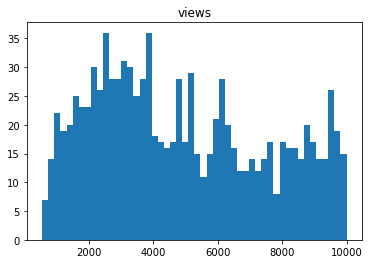

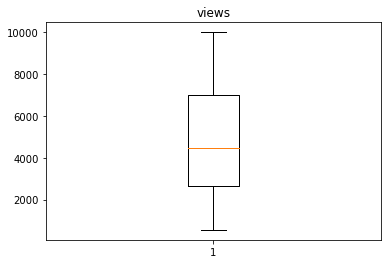

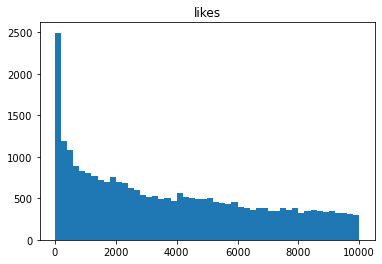

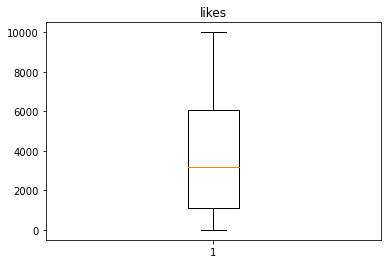

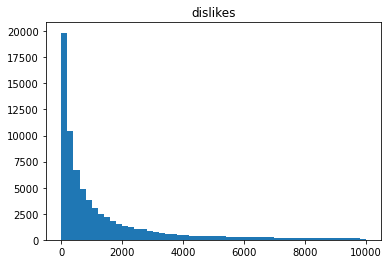

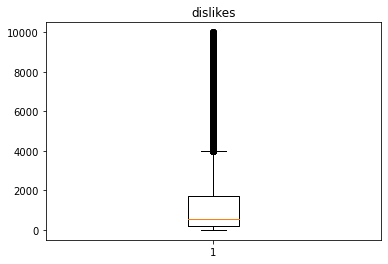

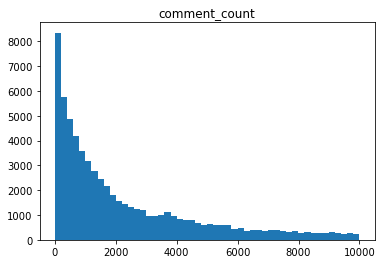

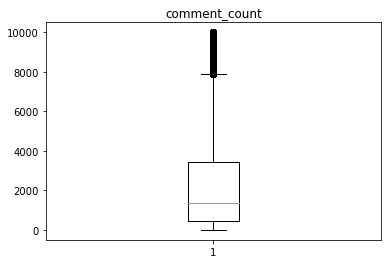

Liczby wartości 'nan'
Atrybut category_id: 75933
Atrybut views: 0
Atrybut likes: 0
Atrybut dislikes: 0
Atrybut comment_count: 0


In [9]:
numeric_attrs = ["category_id", "views", "likes", "dislikes", "comment_count"]

nan_counts = dict()
categories_dict = get_categories_dict()

for attr in numeric_attrs:
    plt.title(attr)
    nan_counts[attr] = videos[attr].isna().sum()
    if attr !=  "category_id":
        table =  videos[videos[attr] < 10_000]
        plt.hist(table[attr], bins=50)
        # TODO better x axis - pomyśleć nad odrzuceniem obserwacji odstających
        plt.show()
        plt.title(attr)
        plt.boxplot(table[attr])
        plt.show()
    else:
        attr_c = videos[attr].value_counts()
        attr_c = attr_c.rename_axis(attr).reset_index(name="count")
        labels = [categories_dict[i] for i in attr_c[attr]]
        plt.bar(labels, attr_c["count"])
        plt.xticks(rotation=270, fontsize=15)
        plt.show()


print("Liczby wartości 'nan'")
for key in nan_counts.keys():
    print(f"Atrybut {key}: {nan_counts[key]}")

### Atrybuty tekstowe

brakuje aż 727 identyfikatorów filmów
dodatkowo mamy powtórzenia w nich

In [10]:
string_attributes = ["video_id", "title", "channel_title", "tags",
                     "thumbnail_link", "description"]

             count
count  8511.000000
mean      9.383739
std      11.580377
min       1.000000
25%       4.000000
50%       7.000000
75%      12.000000
max     727.000000
         video_id  count
0         #NAZWA?    727
1     8h--kFui1JA     66
2     vjSohj-Iclc     62
3     l884wKofd54     61
4     VYOjWnS4cMY     61
...           ...    ...
8506  0enOVnTDmqA      1
8507  9FVkXIj-wLQ      1
8508  pkwSoJrVWAY      1
8509  NJcShzy0lMM      1
8510  Xk_Gv89jzas      1

[8511 rows x 2 columns]


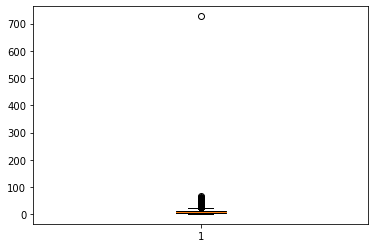

In [11]:
video_counts = videos["video_id"].value_counts()
video_counts = video_counts.rename_axis("video_id").reset_index(name="count")

print(video_counts.describe())

print(video_counts)
plt.boxplot(video_counts["count"])
plt.show()

Tytuły filmów

powtórzenia w tytułach większość najczęściej występujących to tytuły piosenek - teledyski
piosenek


In [12]:
title_counts = videos["title"].value_counts()
title_counts = title_counts.rename_axis("title").reset_index(name="count")

print(title_counts)

title_counts.describe()

                                                  title  count
0           Sam Smith - Pray (Official Video) ft. Logic     66
1                              Getting some air, Atlas?     62
2     Enrique Iglesias - MOVE TO MIAMI (Official Vid...     61
3     Childish Gambino - This Is America (Official V...     61
4     Kelly Clarkson - Meaning of Life [Official Video]     60
...                                                 ...    ...
8787  Kendrick Lamar, U2, Dave Chappelle - Performan...      1
8788                      Brian Justin Crum - Wild Side      1
8789  Boston Celtics vs Milwaukee Bucks Full Game Hi...      1
8790  BREAKING NEWS: Zimbabwe's President Mugabe res...      1
8791                   Gentoo Linux on a 486 PC in 2018      1

[8792 rows x 2 columns]


,count
count,8792.000000
mean,9.083826
std,8.497842
min,1.000000
25%,3.000000
50%,7.000000
75%,12.000000
max,66.000000


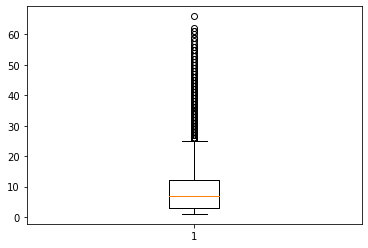

In [13]:
plt.boxplot(title_counts["count"])
plt.show()

Channel title

Linki do obrazów - także są powtórzenia, nie ma braków

                                      thumbnail_link  count
0     https://i.ytimg.com/vi/8h--kFui1JA/default.jpg     66
1     https://i.ytimg.com/vi/vjSohj-Iclc/default.jpg     62
2     https://i.ytimg.com/vi/VYOjWnS4cMY/default.jpg     61
3     https://i.ytimg.com/vi/l884wKofd54/default.jpg     61
4     https://i.ytimg.com/vi/BspHjvU11y4/default.jpg     60
...                                              ...    ...
8603  https://i.ytimg.com/vi/6m0lnvcQPP0/default.jpg      1
8604  https://i.ytimg.com/vi/k3PEl45DjkA/default.jpg      1
8605  https://i.ytimg.com/vi/0WPYpeJA__U/default.jpg      1
8606  https://i.ytimg.com/vi/xl3HhY2BTuU/default.jpg      1
8607  https://i.ytimg.com/vi/pi0ePRY7TSc/default.jpg      1

[8608 rows x 2 columns]
             count
count  8608.000000
mean      9.277997
std       8.563351
min       1.000000
25%       4.000000
50%       7.000000
75%      12.000000
max      66.000000


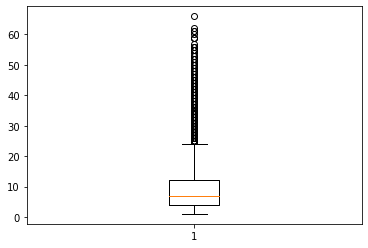

In [14]:
thumbnail_counts = videos["thumbnail_link"].value_counts()
thumbnail_counts = thumbnail_counts.rename_axis("thumbnail_link").reset_index(name="count")

print(thumbnail_counts)
print(thumbnail_counts.describe())


plt.boxplot(thumbnail_counts["count"])
plt.show()

tytuły kanałów
także powtózenia - sprawdzić to jimmy fallon

             count
count  3099.000000
mean     25.771217
std      41.908339
min       1.000000
25%       5.000000
50%      11.000000
75%      27.000000
max     405.000000
                               channel_title  count
0     The Tonight Show Starring Jimmy Fallon    405
1                               TheEllenShow    400
2                          Jimmy Kimmel Live    393
3                        Saturday Night Live    381
4                                    Netflix    380
...                                      ...    ...
3094                           JoanJetsetter      1
3095                          Birdbox Studio      1
3096                              Missguided      1
3097                  That Japanese Man Yuta      1
3098                                    Nico      1

[3099 rows x 2 columns]


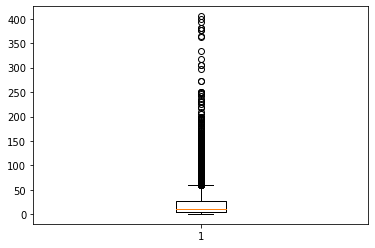

In [15]:
channel_title_counts = videos["channel_title"].value_counts()
channel_title_counts = channel_title_counts.rename_axis("channel_title").reset_index(name="count")

print(channel_title_counts.describe())

print(channel_title_counts)
plt.boxplot(channel_title_counts["count"])
plt.show()



Opisy filmów

mamy także powtórzenia nawet na opisach filmów

sprawdzić ilość 'nan' description

TODO można zliczyć jescze liczbę linków na opis  i sprawdzić najczęściej pojawiające się portale

              count
count  10391.000000
mean       7.572226
std        7.034861
min        1.000000
25%        3.000000
50%        6.000000
75%       10.000000
max      135.000000
                                             description  count
0      ► Listen LIVE: http://power1051fm.com/\n► Face...    135
1      Every Friday on TMZ Sports UFC Welterweight Ch...     78
2                                        The White House     76
3      SZA's CTRL available on:Apple Music - http://s...     68
4      Stream, Download and Listen to Pray feat. Logi...     62
...                                                  ...    ...
10386  We try to make the Little Tikes Cozy Coupe fro...      1
10387  Hey Larlees, todays video is me testing Crayol...      1
10388  Austrian Marcel Hirscher continued his dominan...      1
10389  화려한 골든 에이지의 시작! Wanna One 2nd Mini Album 0+1=1...      1
10390  'Get Out' star Daniel Kaluuya says that 'I've ...      1

[10391 rows x 2 columns]


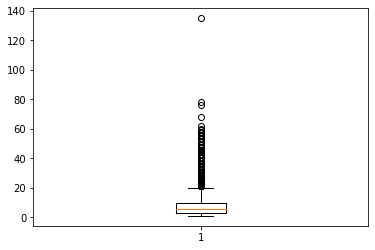

In [36]:
description_counts = videos["description"].value_counts()
description_counts = description_counts.rename_axis("description").reset_index(name="count")

print(description_counts.describe())

print(description_counts)
plt.boxplot(description_counts["count"])
plt.show()

  0%|          | 0/79865 [00:00<?, ?it/s]

79865
Nan: 1219
                                                words
0                                               click
1                                             continu
2                                               stori
3                                                make
4                                             monster
...                                               ...
6645538                 http://twitter.com/callofduti
6645539        http://twitter.com/treyarch;instagram:
6645540               http://instagram.com/callofduti
6645541  http://www.instagram.com/treyarch/;snapchat:
6645542                                    callofduti

[6645543 rows x 1 columns]
                                          words   count
0                                            --  201985
1                                         video   63274
2                                            's   50391
3                                        follow   43983
4                           

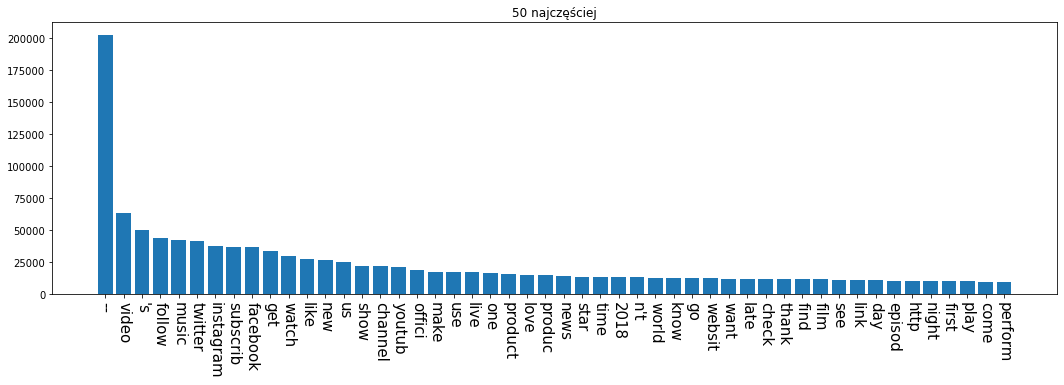

In [38]:
description_nan_count = 0
if os.path.exists("description_words.csv"):
    words = pd.read_csv("description_words.csv")
    words = words["words"].to_frame()
    with open("tokenized_descriptions.json", "r") as file:
        tokenized_descriptions = json.load(file)
        file.close()
    for i in tqdm(tokenized_descriptions):
        if not i:
            description_nan_count += 1
else:
    words = pd.DataFrame()
    tokenized_descriptions = []
    for i in tqdm(range(len(videos))):
        text = videos["description"].iloc[i]
        if isinstance(text, str):
            tokens = Tokenizer.tokenize(text)
            tokenized_descriptions.append(tokens)
            words = words.append(pd.DataFrame(data={"words": Tokenizer.tokenize(videos["description"].iloc[i])}), ignore_index=True)
        elif isinstance(text, float):
            if math.isnan(text):
                description_nan_count += 1
                tokenized_descriptions.append([])
        else:
            print(text, type(text))
            tokenized_descriptions.append([])
    words.to_csv("description_words.csv")
    with open("tokenized_descriptions.json", "w") as file:
        json.dump(tokenized_descriptions, file)
        file.close()
print(len(tokenized_descriptions))
print(f"Nan: {description_nan_count}")
print(words)
words_counts = words.value_counts()
words_counts = words_counts.rename_axis("words").reset_index(name="count")
print(words_counts)
wh = words_counts.head(50)
plt.subplots(figsize=(18,5))
plt.bar(wh["words"], wh["count"])
plt.title("50 najczęściej")
plt.xticks(rotation=270, fontsize=15)
plt.show()

In [ ]:
# TODO preprocess title
# print(videos["description"])

# TODO most frequent words in titles


Video_id — słaby atrybut, ponieważ jest to tylko id generowane, nie wności żadniej wiedzy

Thumbnail link też słaby (jako sam tekst) - tylko link do obrazka, ale obrazek może wnieśc więcej wiedzy

Channel_title — być może słowa kluczowe będą znaczące ale ten atrubut chyba nie wności jakiejś
super wiedzy.

Zmienne logiczne, jeśli przyjmie wartość prawda to prawdopodobieństwo bycia
w trending znacznie spada.